In [131]:
%pylab
%matplotlib inline
from numba import jit, njit

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


/home/mike/.conda/envs/idp/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Problem 2: Harmonic Oscillator Comparison

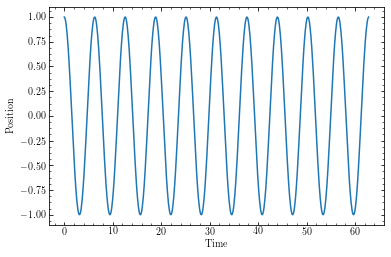

In [157]:
Tmax = 10*2*np.pi
dt = 0.1
times = np.arange(0,Tmax,dt)
y_analytic = np.cos(times)

plt.plot(times, y_analytic, label="Analytic")
plt.xlabel("Time")
plt.ylabel("Position")
plt.show()

Let's get our general-purpose Euler and midpoint methods up and running

In [158]:
def Euler(deriv, y0, dt, T):
    y = [y0,]
    t = [0,]
    Nsteps = int(T/dt + 0.5)
    for i in range(Nsteps):
        y.append(y[-1] + dt*deriv(y[-1], t[-1]))
        t.append(i * dt)
    return np.array(t), np.array(y)

def Midpoint(deriv, y0, dt, T):
    y = [y0,]
    t = [0,]
    Nsteps = int(T/dt + 0.5)
    for i in range(Nsteps):
        y_mid = y[-1] + dt/2 * deriv(y[-1], t[-1])
        t_mid = t[-1] + dt/2
        y.append(y[-1] + dt * deriv(y_mid, t_mid))
        t.append((i+1) * dt)
    return np.array(t), np.array(y)


methods = {"Euler": Euler, "Midpoint": Midpoint}

Now solve the harmonic oscillator problem with the different methods

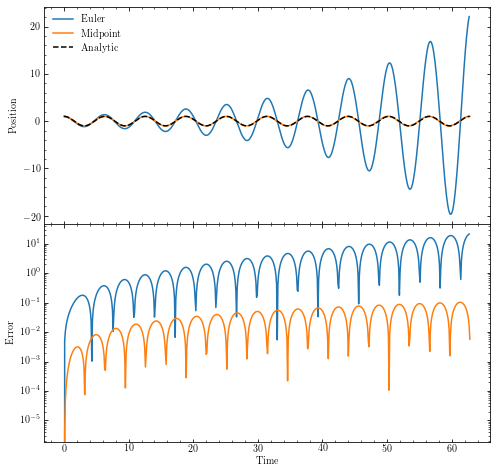

In [159]:
deriv = lambda x, t: np.array([x[1], -x[0]])

y0 = np.array([1., 0.])
fig, axes = plt.subplots(2, sharex=True, figsize=(8,8))
for key, method in methods.items():
    t, y = method(deriv, y0, 0.1, Tmax)
    axes[0].plot(t, y[:,0], label=key)
    axes[1].plot(t, np.abs(y[:,0]-np.cos(t)),label=key)
axes[0].plot(times, np.cos(times), label="Analytic", ls='dashed', color='black')
axes[1].set_yscale('log')
axes[1].set_xlabel("Time")
axes[0].set_ylabel("Position")
axes[0].legend()
axes[1].set_ylabel("Error")
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

Now let's check the convergence rates by trying a grid of timesteps

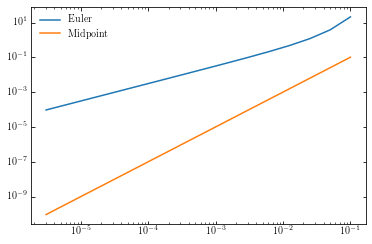

In [160]:
dts = 0.1 / (1 << np.arange(16)) # range of timesteps we'll try

errors = {}
for m, method in methods.items():
    errors[m] = []
    for dt in dts:
        t, y = method(deriv, y0, dt, Tmax)
        errors[m].append(np.max(np.abs(y[:,0]-np.cos(t))))
    #t_euler, y_euler = Euler(deriv, y0, dt, Tmax)
    #t_mid, y_mid = Midpoint(deriv, y0, dt, Tmax)
    plt.plot(dts, errors[m], label=m)
plt.loglog()
plt.legend()
plt.show()

# RK4 Method

In [173]:
def RK4Step(yold, t, h, deriv):
    k1 = h * deriv(yold, t) # euler step
    k2 = h * deriv(yold + 0.5*k1, t + 0.5*h) # midpoint step
    k3 = h * deriv(yold + 0.5*k2, t + 0.5*h) # refined midpoint step
    k4 = h * deriv(yold + k3, t + h) # whole step using the refined midpoint step
    return yold + k1/6 + k2/3 + k3/3 + k4/6

def RK4(deriv, y0, dt, T):
    y = [y0,]
    t = [0,]
    Nsteps = int(T/dt + 0.5)
    for i in range(Nsteps):
        y.append(RK4Step(y[-1],t[-1],dt,deriv))
        t.append((i+1) * dt)
    return np.array(t), np.array(y)

methods["RK4"] = RK4

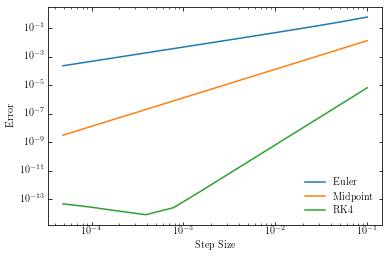

In [163]:
dts = 0.1 / (1 << np.arange(12)) # range of timesteps we'll try

errors = {}
Tmax = 10.
for m, method in methods.items():
    errors[m] = []
    for dt in dts:
        t, y = method(deriv, y0, dt, Tmax)
        errors[m].append(np.max(np.abs(y[:,0]-np.cos(t))))
    #t_euler, y_euler = Euler(deriv, y0, dt, Tmax)
    #t_mid, y_mid = Midpoint(deriv, y0, dt, Tmax)
    plt.plot(dts, errors[m], label=m)
plt.loglog()
plt.xlabel("Step Size")
plt.ylabel("Error")
plt.legend()
plt.show()

# Orbital Motion

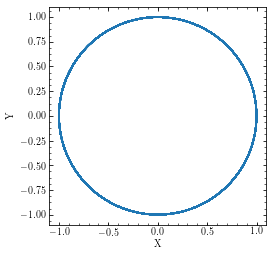

In [171]:
def KeplerianDeriv(y, t):
    #deriv = np.empty(4)
    pos, v = y[:2], y[2:]
    r3 = np.sqrt(pos[0]*pos[0] + pos[1]*pos[1])
    r3 = r3*r3*r3
    accel = -pos/r3
    return np.array([v[0],v[1],accel[0],accel[1]])

#initial conditions for a circular orbit
y0 = np.array([1., 0., 0., 1.])
Tmax = 100 * 2 * np.pi

t_rk4, y_rk4 = RK4(KeplerianDeriv, y0, 0.1, Tmax)

plt.plot(y_rk4[:,0], y_rk4[:,1])
plt.axes().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Symplectic Methods

Here we'll implement the leapfrog integrator for the Kepler problem and see how it stacks up against RK4 by comparing conservation properties

-8.753010769735337e-05 -8.751329795952945e-05
-2.792965222486732e-06 6.8833827526759706e-15


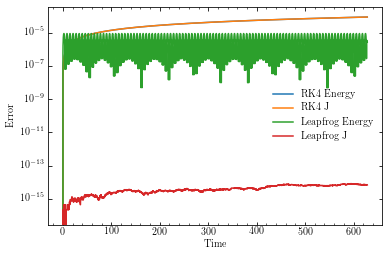

In [187]:
def KeplerLeapfrogStep(yold, t, h, deriv):
    pos, v = yold[:2], yold[2:]
    r3 = np.sqrt(pos[0]*pos[0] + pos[1]*pos[1])
    r3 = r3*r3*r3
    a_old = -pos/r3
    
    pos += v*h + 0.5*h*h*a_old
    r3 = np.sqrt(pos[0]*pos[0] + pos[1]*pos[1])
    r3 = r3*r3*r3
    a_new = -pos/r3
    v += h * (a_old + a_new)/2
    return np.array([pos[0], pos[1], v[0], v[1]])
    
def KeplerLeapfrog(deriv, y0, dt, T):
    y = [y0,]
    t = [0,]
    Nsteps = int(T/dt + 0.5)
    for i in range(Nsteps):
        y.append(KeplerLeapfrogStep(y[-1],t[-1],dt,deriv))
        t.append((i+1) * dt)
    return np.array(t), np.array(y)

def SpecAngMomentum(y):
    return y[:,0]*y[:,3] - y[:,1]*y[:,2]

def Energy(y):
    return 0.5 * (y[:,2]*y[:,2] + y[:,3]*y[:,3]) - (y[:,0]*y[:,0] + y[:,1]*y[:,1])**-0.5

methods = {"RK4": RK4, "Leapfrog": KeplerLeapfrog}
for name, method in methods.items():
    t, y = method(KeplerianDeriv, y0, 0.1, Tmax)
    
    energy = Energy(y)
    j = SpecAngMomentum(y)
    print(energy[-1]-energy[0], j[-1]-j[0])
    plt.plot(t, np.abs(energy-energy[0]), label= name + " Energy")
    plt.plot(t, np.abs(j - j[0]), label = name + " J")
plt.ylabel("Error")
plt.xlabel("Time")
plt.yscale('log')
plt.legend()
plt.show()

#plt.plot(y_leap[:,0], y_leap[:,1])
#plt.axes().set_aspect('equal')
#plt.xlabel("X")
#plt.ylabel("Y")
#plt.show()


The leapfrog gives superior conservation over 100 orbits.